
MIT Open Source License: <br>
Copyright (c) 2018 Daniel C. Elton 

<sub>Permission is hereby granted, free of charge, to any person obtaining a copy</sub>
<sub>of this software and associated documentation files (the "Software"), to deal</sub>
<sub>in the Software without restriction, including without limitation the rights</sub>
<sub>to use, copy, modify, merge, publish, distribute, sublicense, and/or sell</sub>
<sub>copies of the Software, and to permit persons to whom the Software is</sub>
<sub>furnished to do so, subject to the following conditions:</sub>

<sub>The above copyright notice and this permission notice shall be included in all</sub>
<sub>copies or substantial portions of the Software.</sub>

<sub>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR</sub>
<sub>IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,</sub>
<sub>FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE</sub>
<sub>AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER</sub>
<sub>LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,</sub>
<sub>OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE</sub>
<sub>SOFTWARE.</sub>


In [1]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
#from keras_tqdm import TQDMNotebookCallback
from sklearn import cross_validation
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LinearRegression, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

#Read the data
data = pd.read_excel('../datasets/Huang_Massa_data_with_all_SMILES.xlsx', skipfooter=1)

#Add create Mol objects for use with RDkit
data['Mols'] = data['SMILES'].apply(Chem.MolFromSmiles)
num_mols = len(data)

#target_prop = 'Shock velocity (km/s)'
target_prop = 'Explosive energy (kj/cc)'


#Make target variable: 
y = data[target_prop].values

for column in list(data.columns):
    print(column)
    


/home/delton/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/delton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


num
Molecular Name
Formula
Density (g/cm3)
Delta Hf solid (kj/mol)
Explosive energy (kj/cc)
Shock velocity (km/s)
Particle velocity (km/s)
Speed of sound (km/s)
Pressure (Gpa)
T(K)
TNT Equiv (per cc)
group
SMILES
NOTE
Mols


## Quick comparison of fingerprints in fp_list 


In [3]:
from mmltoolkit.fingerprints import * 

fp_list = make_fingerprints(list(data['Mols']), length = 200)

test_fingerprints(fp_list, Lasso(alpha=1e-3, max_iter=10000), y, verbose=False)

\begin{tabular}{c c}
           name        &  avg abs error in CV (kJ/cc) \\
\hline
 E-state (fixed length) (1995) & 0.498 \\
                 Avalon (2006) & 0.872 \\
 ECFPs/Morgan Circular (2010)  & 0.954 \\
    Topological Torsion (1987) & 1.034 \\
              Atom pair (1985) & 1.051 \\
      RDKit topological (2006) & 1.072 \\
\end{tabular}


# Plot fingerprint performance vs length


In [6]:
import warnings
import matplotlib.pyplot as plt
from mmltoolkit.CV_tools import * 
from sklearn.model_selection import KFold, ShuffleSplit


warnings.filterwarnings("ignore", category=RuntimeWarning)

def test_fingerprint_vs_size(mols, model, num_sizes_to_test=10 , max_size=800,
                             cv= KFold(n_splits=20,shuffle=True,random_state=10), 
                             verbose=False, makeplot=False, model_name=""):

    fp_list = make_fingerprints(mols, length = 10) #test run to find number of fingerprints
    num_fp = len(fp_list)

    sizes = np.linspace(10, max_size, num_sizes_to_test) 

    scores_vs_size = np.zeros([num_fp, num_sizes_to_test])
 
    num_fp = 0
    for i in range(num_sizes_to_test):
        if verbose: print(i, ",", end='')
        length = sizes[i]
        fp_list = make_fingerprints(mols, length = int(length))
        num_fp = len(fp_list)
        for j in range(num_fp):
            scores_vs_size[j,i] = test_model_cv(model, fp_list[j].x, y, cv=cv)
            
    if (makeplot):
        fig = plt.figure(figsize=(10,9))
        fp_names = []
        for i in range(num_fp):
            if (fp_list[i].name == 'E-state (fixed length) (1995)'):
                plt.plot(sizes, scores_vs_size[i,:],'--')
            else:
                plt.plot(sizes, scores_vs_size[i,:],'-')
            fp_names += [fp_list[i].name]

               
        #plt.title(target_prop+" "+model_name+' average CV score vs fingerprint length',fontsize=25)
        #plt.title(target_prop+" "+model_name+' average CV score vs fingerprint length',fontsize=25)
        plt.ylabel('mean absolute error (kJ/cc)',fontsize=22)
        plt.xlabel('fingerprint length (bits)', fontsize=22)
        plt.legend(fp_names,fontsize=16)
        ax = plt.gca()
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        #plt.yscale('log')
        #plt.ylim([.95*min(scores_vs_size),.9])
        plt.savefig('fingerprints_vs_length.pdf')
        plt.show()
          
    return (plt, scores_vs_size)



0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,

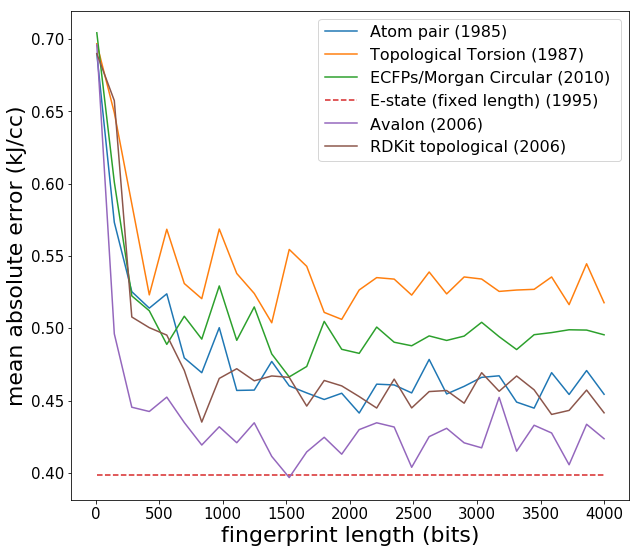

In [8]:
plt2, scores_vs_size = test_fingerprint_vs_size(list(data['Mols']), 
                                          BayesianRidge(), verbose=True, 
                                          makeplot=True, max_size=4000, num_sizes_to_test=30, 
                                          model_name='Bayesian Ridge Regression')

In [ ]:
plt, scores_vs_size = test_fingerprint_vs_size(list(data['Mols']), 
                                          Ridge(), verbose=True, 
                                          makeplot=True,  max_size=2000, num_sizes_to_test=20,
                                          model_name='Ridge Regression')

0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,

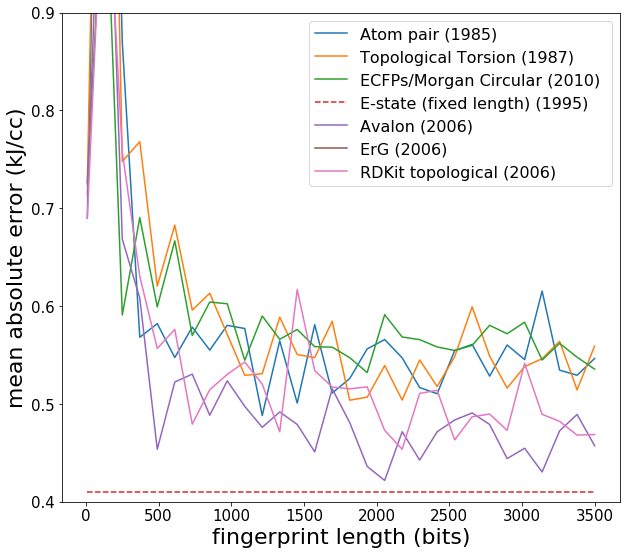

In [28]:
plt, scores_vs_size = test_fingerprint_vs_size(list(data['Mols']), 
                                          KernelRidge(**{'alpha': 1.1937766417144357e-07, 'gamma': 6.9519279617756056e-06, 'kernel': 'rbf'}), verbose=True, 
                                           makeplot=True,  max_size=3500, num_sizes_to_test=30,
                                          model_name='Kernel Ridge Regression')

In [ ]:
#Scale X to unit variance and zero mean
data['Fingerprint'] = data['Mols'].apply(fp_Estate_ints)

KRmodel = GridSearchCV(KernelRidge(), cv=5,
              param_grid={"alpha": np.logspace(-10, 10, 40),
             "gamma": np.logspace(-8, 10, 20),
              "kernel" : ['rbf', 'laplacian']},
             scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(X, y)
Best_KernelRidge = KRmodel.best_estimator_
print("Best Kernel Ridge model")
print(KRmodel.best_params_)
print(-1*KRmodel.best_score_)
#KRmodel.grid_scores_


In [ ]:
#Scale X to unit variance and zero mean
data['Fingerprint'] = data['Mols'].apply(fp_Estate_ints)

st = StandardScaler()
Xs = np.array(list(data['Fingerprint']))
Xs = st.fit_transform(X)  #X = np.array(list(data['Fingerprint']))

KRmodel = GridSearchCV(KernelRidge(), cv=5,
              param_grid={"alpha": np.logspace(-10, 10, 40),
             "gamma": np.logspace(-8, 10, 20),
              "kernel" : ['rbf', 'laplacian']},
             scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(Xs, y)
Best_KernelRidge = KRmodel.best_estimator_
print("Best Kernel Ridge model")
print(KRmodel.best_params_)
print(-1*KRmodel.best_score_)
#KRmodel.grid_scores_